In [22]:
import os
import copy
import pickle
import warnings
import pandas as pd
import numpy as np
import numpy.ma as ma
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
from scipy.stats import bootstrap

import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
from matplotlib.ticker import NullLocator

import palettable
import deepdish as dd


from astropy.utils.console import ProgressBar
from astropy.table import QTable
plt.rc('text', usetex=True)
rcParams.update({'axes.linewidth': 1.5})
rcParams.update({'xtick.direction': 'in'})
rcParams.update({'ytick.direction': 'in'})
rcParams.update({'xtick.minor.visible': 'True'})
rcParams.update({'ytick.minor.visible': 'True'})
rcParams.update({'xtick.major.pad': '7.0'})
rcParams.update({'xtick.major.size': '8.0'})
rcParams.update({'xtick.major.width': '1.5'})
rcParams.update({'xtick.minor.pad': '7.0'})
rcParams.update({'xtick.minor.size': '4.0'})
rcParams.update({'xtick.minor.width': '1.5'})
rcParams.update({'ytick.major.pad': '7.0'})
rcParams.update({'ytick.major.size': '8.0'})
rcParams.update({'ytick.major.width': '1.5'})
rcParams.update({'ytick.minor.pad': '7.0'})
rcParams.update({'ytick.minor.size': '4.0'})
rcParams.update({'ytick.minor.width': '1.5'})
rcParams.update({'axes.titlepad': '10.0'})
rcParams.update({'font.size': 28})

In [2]:
data_dir="/Users/xushuo/work/Submit/Simulation/data/"
fig_dir="/Users/xushuo/work/Papers/Simulation/Figure/"

In [3]:
#additional hdf5 file for this plot 
fname="galaxies_3sim_correct.hdf5"

In [4]:
#SHMR relation for ex-situ stellar
slope_aper_tab0=dd.io.load(data_dir+fname,'/exs/physical_fit/direct/slope_aperture')
slope_out_tab0=dd.io.load(data_dir+fname,'/exs/physical_fit/direct/slope_outskirt')
scatter_aper_tab0=dd.io.load(data_dir+fname,'/exs/physical_fit/direct/scatter_aperture')
scatter_out_tab0=dd.io.load(data_dir+fname,'/exs/physical_fit/direct/scatter_outskirt')

In [5]:
slope_aper_tab1=dd.io.load(data_dir+fname,'/exs/physical_fit/uncertainty/slope_aperture')
slope_out_tab1=dd.io.load(data_dir+fname,'/exs/physical_fit/uncertainty/slope_outskirt')
scatter_aper_tab1=dd.io.load(data_dir+fname,'/exs/physical_fit/uncertainty/scatter_aperture')
scatter_out_tab1=dd.io.load(data_dir+fname,'/exs/physical_fit/uncertainty/scatter_outskirt')

In [6]:
slope_aper_tab2=dd.io.load(data_dir+fname,'/exs/reff_fit/direct/slope_aperture')
slope_out_tab2=dd.io.load(data_dir+fname,'/exs/reff_fit/direct/slope_outskirt')
scatter_aper_tab2=dd.io.load(data_dir+fname,'/exs/reff_fit/direct/scatter_aperture')
scatter_out_tab2=dd.io.load(data_dir+fname,'/exs/reff_fit/direct/scatter_outskirt')

In [7]:
slope_aper_tab3=dd.io.load(data_dir+fname,'/exs/reff_fit/uncertainty/slope_aperture')
slope_out_tab3=dd.io.load(data_dir+fname,'/exs/reff_fit/uncertainty/slope_outskirt')
scatter_aper_tab3=dd.io.load(data_dir+fname,'/exs/reff_fit/uncertainty/scatter_aperture')
scatter_out_tab3=dd.io.load(data_dir+fname,'/exs/reff_fit/uncertainty/scatter_outskirt')

In [8]:
color_list=['steelblue','orangered','darkblue']

In [9]:
tab=dd.io.load(data_dir+'galaxies_tng300_072_correct.hdf5','/physical_mass')

In [10]:
sma_list=np.asarray([30,50,75,100,150])
mass_bin=np.arange(11.2,12.5,0.1)
apersize=np.asarray([30,50,100,150])
outer=np.asarray([30,50,75])

In [11]:
scatter_aper_tab=scatter_aper_tab0[scatter_aper_tab0['aperture_size']!=75]
slope_aper_tab=slope_aper_tab0[slope_aper_tab0['aperture_size']!=75]
slope_out_tab=slope_out_tab0
scatter_out_tab=scatter_out_tab0
scatter_aper_tab_mock=scatter_aper_tab1[scatter_aper_tab1['aperture_size']!=75]
slope_aper_tab_mock=slope_aper_tab1[slope_aper_tab1['aperture_size']!=75]
slope_out_tab_mock=slope_out_tab1
scatter_out_tab_mock=scatter_out_tab1

In [12]:
def mpeakfind(tab,bin_num=30):
    numb,bins=np.histogram(tab,bins=bin_num)
    max_value=max(numb)
    max_index=list(numb).index(max_value)
    mpeak=bins[max_index]
    return mpeak

In [13]:
def linear1d(x,a,b):
    return a*x+b

In [14]:
tab1=tab

In [15]:
slope_ins_tab={}
slope_ins_err={}
for proj in ('xy','yz','xz'):
    mask=(tab['catsh_primary']==True)&(tab['proj']==proj)&(tab['mass_stellar_ins']>1e10)&(tab['mass_stellar_exs']>10**10.5)
    mpeak=mpeakfind(np.log10(tab['mass_stellar_ins'][mask]))
    mask0=(tab['mass_stellar_ins']>10**mpeak)
    ydata=np.log10(tab['mass_halo'][mask&mask0])
    xdata=np.log10(tab['mass_stellar_ins'][mask&mask0])
    popt,pcov=curve_fit(linear1d,xdata,ydata)
    slope_ins_tab[proj]=popt[0]
    slope_ins_err[proj]=np.sqrt(pcov[0,0])
slope_exs_tab={}
slope_exs_err={}
for proj in ('xy','yz','xz'):
    mask=(tab['catsh_primary']==True)&(tab['proj']==proj)&(tab['mass_stellar_ins']>1e10)&(tab['mass_stellar_exs']>10**10.5)
    mpeak=mpeakfind(np.log10(tab['mass_stellar_exs'][mask]))
    mask0=(tab['mass_stellar_exs']>10**mpeak)
    ydata=np.log10(tab['mass_halo'][mask&mask0])
    xdata=np.log10(tab['mass_stellar_exs'][mask&mask0])
    popt,pcov=curve_fit(linear1d,xdata,ydata)
    slope_exs_tab[proj]=popt[0]
    slope_exs_err[proj]=np.sqrt(pcov[0,0])
scatter_ins_tab={}
scatter_ins_err1={}
scatter_ins_err2={}
for proj in ('xy','yz','xz'):
    mask=(tab['catsh_primary']==True)&(tab['proj']==proj)&(tab['mass_stellar_ins']>1e10)&(tab['mass_stellar_exs']>10**10.5)
    mpeak=mpeakfind(np.log10(tab['mass_stellar_ins'][mask]))
    mask0=(tab['mass_stellar_ins']>10**mpeak)
    std=np.std(np.log10(tab['mass_halo'][mask&mask0])-slope_ins_tab[proj]*np.log10(tab['mass_stellar_ins'][mask&mask0]),ddof=1)
    data=np.log10(tab['mass_halo'][mask&mask0])-slope_ins_tab[proj]*np.log10(tab['mass_stellar_ins'][mask&mask0])
    err=bootstrap((data,),np.std,n_resamples=8000,confidence_level=0.7)
    scatter_ins_err1[proj]=err.confidence_interval[0]
    scatter_ins_err2[proj]=err.confidence_interval[1]
    scatter_ins_tab[proj]=std
scatter_exs_tab={}
scatter_exs_err1={}
scatter_exs_err2={}
for proj in ('xy','yz','xz'):
    mask=(tab['catsh_primary']==True)&(tab['proj']==proj)&(tab['mass_stellar_ins']>1e10)&(tab['mass_stellar_exs']>10**10.5)
    mpeak=mpeakfind(np.log10(tab['mass_stellar_exs'][mask]))
    mask0=(tab['mass_stellar_exs']>10**mpeak)
    std=np.std(np.log10(tab['mass_halo'][mask&mask0])-slope_exs_tab[proj]*np.log10(tab['mass_stellar_exs'][mask&mask0]),ddof=1)
    data=np.log10(tab['mass_halo'][mask&mask0])-slope_exs_tab[proj]*np.log10(tab['mass_stellar_exs'][mask&mask0])
    err=bootstrap((data,),np.std,n_resamples=8000,confidence_level=0.7)
    scatter_exs_err1[proj]=err.confidence_interval[0]
    scatter_exs_err2[proj]=err.confidence_interval[1]
    scatter_exs_tab[proj]=std

In [16]:
scatter_exs_tab['yz']

0.19721499392068256

In [17]:
slope_out_tab

outskirt_inner_size,slope_out_exs_t300,slope_out_exs_t300_err,slope_out_exs_t100,slope_out_exs_t100_err,slope_out_exs_ori,slope_out_exs_ori_err
int64,float64,float64,float64,float64,float64,float64
30,1.048998156091086,0.016538073413475067,0.9342463780257748,0.05191854344122577,0.8485616970455477,0.03555940834787205
50,0.965970144408382,0.01413366167670596,0.8656996956407047,0.04879247538486399,0.8467043269336432,0.031893732517870164
75,0.9350270238731788,0.014031436910522816,0.7993509516038366,0.035556247508197206,0.8177251211380115,0.03152627729780295


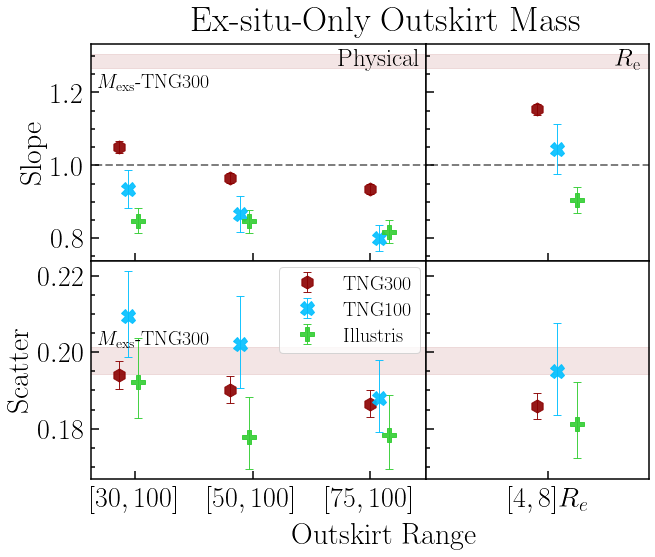

In [23]:
fig=plt.figure(figsize=(10, 8))
gs = fig.add_gridspec(2,2, hspace=0, wspace=0,width_ratios=(0.6,0.4))
(ax21,ax22),(ax41,ax42) = gs.subplots(sharex='col', sharey='row')
projlist=['t300','t100','ori']
color_list=['darkred','deepskyblue','limegreen']
fmtlist=['h','X','P']
mksize_list=[13,14,14]

scatter_aper_tab=scatter_aper_tab0[scatter_aper_tab0['aperture_size']!=75]
slope_aper_tab=slope_aper_tab0[slope_aper_tab0['aperture_size']!=75]
slope_out_tab=slope_out_tab0
scatter_out_tab=scatter_out_tab0
scatter_aper_tab_mock=scatter_aper_tab1[scatter_aper_tab1['aperture_size']!=75]
slope_aper_tab_mock=slope_aper_tab1[slope_aper_tab1['aperture_size']!=75]
slope_out_tab_mock=slope_out_tab1
scatter_out_tab_mock=scatter_out_tab1
apersize=np.asarray([30,60,90,120])
outer=np.asarray([30,50,75])
label_list=['TNG300','TNG100','Illustris']
for ii in range(3):
    mksize=mksize_list[ii]
    label=label_list[ii]
    proj=projlist[ii]
    col=color_list[ii]
    fmt=fmtlist[ii]
    i0=np.asarray([ii,ii,ii])*1.7
    ax21.errorbar(outer+i0,slope_out_tab['slope_out_exs_'+proj],yerr=slope_out_tab['slope_out_exs_'+proj+'_err'],color=col, alpha=0.9, fmt=fmt,
            capsize=4, capthick=1, elinewidth=1, markersize=mksize)
    err1=scatter_out_tab['scatter_out_exs_'+proj]-scatter_out_tab['scatter_out_exs_'+proj+'_err1']
    err2=scatter_out_tab['scatter_out_exs_'+proj+'_err2']-scatter_out_tab['scatter_out_exs_'+proj]
    ax41.errorbar(outer+i0,scatter_out_tab['scatter_out_exs_'+proj],yerr=(err1,err2),color=col, alpha=0.9, 
             capsize=4, capthick=1, elinewidth=1,fmt=fmt,markersize=mksize,label=r'\rm '+label)
"""
for ii in range(3):
    proj=projlist[ii]
    col=color_list[ii]
    fmt=fmtlist[ii]
    i0=np.asarray([ii,ii,ii])*1.7
    ax21.errorbar(outer+i0,slope_out_tab_mock['slope_out_exs_'+proj],mec=col,mfc='White', alpha=0.9, fmt=fmt,
             markersize=10)
    ax41.errorbar(outer+i0,scatter_out_tab_mock['scatter_out_exs_'+proj],mec=col,mfc='White', alpha=0.9, 
             fmt=fmt,markersize=10)
"""


scatter_aper_tab=scatter_aper_tab2[(scatter_aper_tab2['aperture_size']>2)&(scatter_aper_tab2['aperture_size']<9)&(scatter_aper_tab2['aperture_size']!=4)]
slope_aper_tab=slope_aper_tab2[(slope_aper_tab2['aperture_size']>2)&(slope_aper_tab2['aperture_size']<9)&(slope_aper_tab2['aperture_size']!=4)]
slope_out_tab=slope_out_tab2[slope_out_tab2['outskirt_inner_size']==4]
scatter_out_tab=scatter_out_tab2[scatter_out_tab2['outskirt_inner_size']==4]
scatter_aper_tab_mock=scatter_aper_tab3[(scatter_aper_tab3['aperture_size']>2)&(scatter_aper_tab3['aperture_size']<9)&(scatter_aper_tab3['aperture_size']!=4)]
slope_aper_tab_mock=slope_aper_tab3[(slope_aper_tab3['aperture_size']>2)&(slope_aper_tab3['aperture_size']<9)&(slope_aper_tab3['aperture_size']!=4)]
slope_out_tab_mock=slope_out_tab3[slope_out_tab3['outskirt_inner_size']==4]
scatter_out_tab_mock=scatter_out_tab3[scatter_out_tab3['outskirt_inner_size']==4]
apersize=np.asarray([3,6,9])
outer=np.asarray([4])

for ii in range(3):
    mksize=mksize_list[ii]
    label=label_list[ii]
    proj=projlist[ii]
    col=color_list[ii]
    fmt=fmtlist[ii]
    i0=np.asarray([ii])*0.18
    ax22.errorbar(outer+i0,slope_out_tab['slope_out_exs_force_'+proj],yerr=slope_out_tab['slope_out_exs_force_'+proj+'_err'],color=col, alpha=0.9, fmt=fmt,
            capsize=4, capthick=1, elinewidth=1, markersize=mksize)
    err1=scatter_out_tab['scatter_out_exs_force_'+proj]-scatter_out_tab['scatter_out_exs_force_'+proj+'_err1']
    err2=scatter_out_tab['scatter_out_exs_force_'+proj+'_err2']-scatter_out_tab['scatter_out_exs_force_'+proj]
    ax42.errorbar(outer+i0,scatter_out_tab['scatter_out_exs_force_'+proj],yerr=(err1,err2),color=col, alpha=0.9, 
             capsize=4, capthick=1, elinewidth=1,fmt=fmt,markersize=mksize)

"""
for ii in range(3):
    proj=projlist[ii]
    col=color_list[ii]
    fmt=fmtlist[ii]
    i0=np.asarray([ii])*0.18
    ax22.errorbar(outer+i0,slope_out_tab_mock['slope_out_exs_force_'+proj],mec=col,mfc='White', alpha=0.9, fmt=fmt,
             markersize=10)
    ax42.errorbar(outer+i0,scatter_out_tab_mock['scatter_out_exs_force_'+proj],mec=col,mfc='White', alpha=0.9, 
             fmt=fmt,markersize=10)
"""

#ax41.errorbar((10,20),(0.2,0.2),color='black',fmt='h',markersize=10,label=r'\rm Original')
#ax41.errorbar((10,20),(0.2,0.2),mec='black',mfc='White',fmt='h',markersize=10,label=r'\rm + Uncertainty')

x1=np.arange(20,180,20)
x2=np.arange(20,100,10)
y1=slope_exs_tab['xy']+slope_exs_err['xy']+0*x1
y2=slope_exs_tab['xy']-slope_exs_err['xy']+0*x1
y3=scatter_exs_err1['xy']+0*x1
y4=scatter_exs_err2['xy']+0*x1
c0='darkred'  
ax21.fill_between(x2,y1,y2,alpha=0.1,color=c0) 
ax41.fill_between(x2,y3,y4,alpha=0.1,color=c0)   
ax21.plot(x2,1+0*x2,alpha=0.5,color='black',lw=2,ls='--')

x1=np.arange(2,12,1)
x2=np.arange(2,7,0.5)
y1=slope_exs_tab['xy']+slope_exs_err['xy']+0*x1
y2=slope_exs_tab['xy']-slope_exs_err['xy']+0*x1
y3=scatter_exs_err1['xy']+0*x1
y4=scatter_exs_err2['xy']+0*x1
c0='darkred'  
ax22.fill_between(x2,y1,y2,alpha=0.1,color=c0)
ax42.fill_between(x2,y3,y4,alpha=0.1,color=c0)  
ax22.plot(x2,1+0*x2,alpha=0.5,color='black',lw=2,ls='--')



ax21.set_xlim(25,85)

ax22.set_xlim(3,5)

ax21.text(0.3, 1.06, r'\rm Ex-situ-Only Outskirt Mass', transform=ax21.transAxes, size=35)

ax41.text(0.6, -0.3, r'\rm Outskirt Range', transform=ax41.transAxes, size=30)
ax21.text(0.74, 0.9, r'\rm Physical', transform=ax21.transAxes, size=25)
ax22.text(0.85, 0.9, r'$R_{\rm e}$', transform=ax22.transAxes, size=25)
#ax21.text(0.45, 0.75, r'\rm Outer size $=100{\rm kpc}$', transform=ax21.transAxes, size=22)
#ax22.text(0.3, 0.75, r'\rm Outer size $=8R_{\rm e}$', transform=ax22.transAxes, size=22)
#ax11.set_title(r'\rm Aperture',fontsize=30)
#ax31.set_xlabel(r'\rm Aperture Size/kpc',fontsize=25)
#ax32.set_xlabel(r'\rm Aperture Size/$R_{\rm e}$',fontsize=25)
ax21.set_ylabel(r'\rm Slope',fontsize=30)
ax41.set_ylabel(r'\rm Scatter',fontsize=30)
#ax21.set_title(r'\rm Outskirt [$\#$,100]kpc',fontsize=30)
ax41.legend(fontsize=20,loc=1,labelspacing=0.4,borderaxespad=0.3)
#ax31.legend(fontsize=25)
#ax41.legend(fontsize=22,loc=1)
#_= ax41.set_xlabel(r'\rm Outskirt Inner Size/kpc',fontsize=25)
#_= ax42.set_xlabel(r'\rm Outskirt Inner Size/$R_{\rm e}$',fontsize=25)
ax41.text(0.02, 0.62, r'$M_{\rm exs}$-{\rm TNG300}', transform=ax41.transAxes, size=20)
ax21.text(0.02, 0.8, r'$M_{\rm exs}$-{\rm TNG300}', transform=ax21.transAxes, size=20)
ax21.xaxis.set_minor_locator(NullLocator())
ax22.xaxis.set_minor_locator(NullLocator())
ax41.xaxis.set_minor_locator(NullLocator())
ax42.xaxis.set_minor_locator(NullLocator())

ax41.set_xticks([33,54,75],[r'$[30,100]$',r'$[50,100]$',r'$[75,100]$'])
ax42.set_xticks([4.1],[r'$[4,8]R_e$'])


plt.savefig(fig_dir+"Fig6B.png",dpi=100)

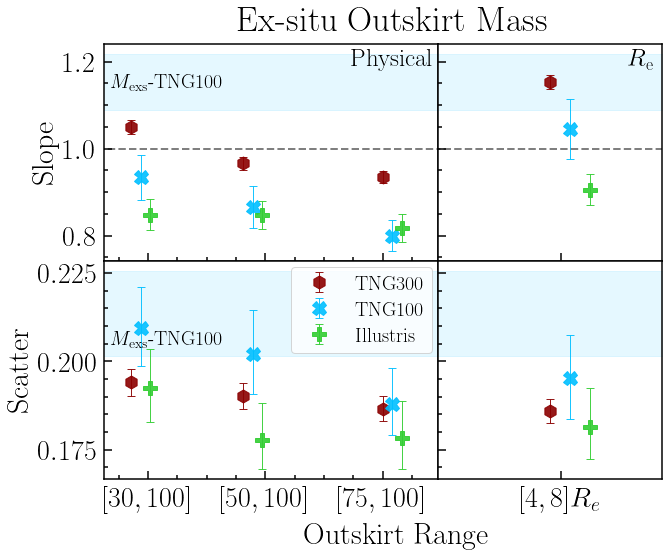

In [23]:
fig=plt.figure(figsize=(10, 8))
gs = fig.add_gridspec(2,2, hspace=0, wspace=0,width_ratios=(0.6,0.4))
(ax21,ax22),(ax41,ax42) = gs.subplots(sharex='col', sharey='row')
projlist=['t300','t100','ori']
color_list=['darkred','deepskyblue','limegreen']
fmtlist=['h','X','P']
mksize_list=[13,14,14]

scatter_aper_tab=scatter_aper_tab0[scatter_aper_tab0['aperture_size']!=75]
slope_aper_tab=slope_aper_tab0[slope_aper_tab0['aperture_size']!=75]
slope_out_tab=slope_out_tab0
scatter_out_tab=scatter_out_tab0
scatter_aper_tab_mock=scatter_aper_tab1[scatter_aper_tab1['aperture_size']!=75]
slope_aper_tab_mock=slope_aper_tab1[slope_aper_tab1['aperture_size']!=75]
slope_out_tab_mock=slope_out_tab1
scatter_out_tab_mock=scatter_out_tab1
apersize=np.asarray([30,60,90,120])
outer=np.asarray([30,50,75])
label_list=['TNG300','TNG100','Illustris']
for ii in range(3):
    mksize=mksize_list[ii]
    label=label_list[ii]
    proj=projlist[ii]
    col=color_list[ii]
    fmt=fmtlist[ii]
    i0=np.asarray([ii,ii,ii])*1.7
    ax21.errorbar(outer+i0,slope_out_tab['slope_out_exs_'+proj],yerr=slope_out_tab['slope_out_exs_'+proj+'_err'],color=col, alpha=0.9, fmt=fmt,
            capsize=4, capthick=1, elinewidth=1, markersize=mksize)
    err1=scatter_out_tab['scatter_out_exs_'+proj]-scatter_out_tab['scatter_out_exs_'+proj+'_err1']
    err2=scatter_out_tab['scatter_out_exs_'+proj+'_err2']-scatter_out_tab['scatter_out_exs_'+proj]
    ax41.errorbar(outer+i0,scatter_out_tab['scatter_out_exs_'+proj],yerr=(err1,err2),color=col, alpha=0.9, 
             capsize=4, capthick=1, elinewidth=1,fmt=fmt,markersize=mksize,label=r'\rm '+label)
"""
for ii in range(3):
    proj=projlist[ii]
    col=color_list[ii]
    fmt=fmtlist[ii]
    i0=np.asarray([ii,ii,ii])*1.7
    ax21.errorbar(outer+i0,slope_out_tab_mock['slope_out_exs_'+proj],mec=col,mfc='White', alpha=0.9, fmt=fmt,
             markersize=10)
    ax41.errorbar(outer+i0,scatter_out_tab_mock['scatter_out_exs_'+proj],mec=col,mfc='White', alpha=0.9, 
             fmt=fmt,markersize=10)
"""


scatter_aper_tab=scatter_aper_tab2[(scatter_aper_tab2['aperture_size']>2)&(scatter_aper_tab2['aperture_size']<9)&(scatter_aper_tab2['aperture_size']!=4)]
slope_aper_tab=slope_aper_tab2[(slope_aper_tab2['aperture_size']>2)&(slope_aper_tab2['aperture_size']<9)&(slope_aper_tab2['aperture_size']!=4)]
slope_out_tab=slope_out_tab2[slope_out_tab2['outskirt_inner_size']==4]
scatter_out_tab=scatter_out_tab2[scatter_out_tab2['outskirt_inner_size']==4]
scatter_aper_tab_mock=scatter_aper_tab3[(scatter_aper_tab3['aperture_size']>2)&(scatter_aper_tab3['aperture_size']<9)&(scatter_aper_tab3['aperture_size']!=4)]
slope_aper_tab_mock=slope_aper_tab3[(slope_aper_tab3['aperture_size']>2)&(slope_aper_tab3['aperture_size']<9)&(slope_aper_tab3['aperture_size']!=4)]
slope_out_tab_mock=slope_out_tab3[slope_out_tab3['outskirt_inner_size']==4]
scatter_out_tab_mock=scatter_out_tab3[scatter_out_tab3['outskirt_inner_size']==4]
apersize=np.asarray([3,6,9])
outer=np.asarray([4])

for ii in range(3):
    mksize=mksize_list[ii]
    label=label_list[ii]
    proj=projlist[ii]
    col=color_list[ii]
    fmt=fmtlist[ii]
    i0=np.asarray([ii])*0.18
    ax22.errorbar(outer+i0,slope_out_tab['slope_out_exs_force_'+proj],yerr=slope_out_tab['slope_out_exs_force_'+proj+'_err'],color=col, alpha=0.9, fmt=fmt,
            capsize=4, capthick=1, elinewidth=1, markersize=mksize)
    err1=scatter_out_tab['scatter_out_exs_force_'+proj]-scatter_out_tab['scatter_out_exs_force_'+proj+'_err1']
    err2=scatter_out_tab['scatter_out_exs_force_'+proj+'_err2']-scatter_out_tab['scatter_out_exs_force_'+proj]
    ax42.errorbar(outer+i0,scatter_out_tab['scatter_out_exs_force_'+proj],yerr=(err1,err2),color=col, alpha=0.9, 
             capsize=4, capthick=1, elinewidth=1,fmt=fmt,markersize=mksize)

"""
for ii in range(3):
    proj=projlist[ii]
    col=color_list[ii]
    fmt=fmtlist[ii]
    i0=np.asarray([ii])*0.18
    ax22.errorbar(outer+i0,slope_out_tab_mock['slope_out_exs_force_'+proj],mec=col,mfc='White', alpha=0.9, fmt=fmt,
             markersize=10)
    ax42.errorbar(outer+i0,scatter_out_tab_mock['scatter_out_exs_force_'+proj],mec=col,mfc='White', alpha=0.9, 
             fmt=fmt,markersize=10)
"""

#ax41.errorbar((10,20),(0.2,0.2),color='black',fmt='h',markersize=10,label=r'\rm Original')
#ax41.errorbar((10,20),(0.2,0.2),mec='black',mfc='White',fmt='h',markersize=10,label=r'\rm + Uncertainty')

x1=np.arange(20,180,20)
x2=np.arange(20,100,10)
y1=slope_exs_tab['xy']+slope_exs_err['xy']+0*x1
y2=slope_exs_tab['xy']-slope_exs_err['xy']+0*x1
y3=scatter_exs_err1['xy']+0*x1
y4=scatter_exs_err2['xy']+0*x1
c0='deepskyblue'  
ax21.fill_between(x2,y1,y2,alpha=0.1,color=c0) 
ax41.fill_between(x2,y3,y4,alpha=0.1,color=c0)   
ax21.plot(x2,1+0*x2,alpha=0.5,color='black',lw=2,ls='--')

x1=np.arange(2,12,1)
x2=np.arange(2,7,0.5)
y1=slope_exs_tab['xy']+slope_exs_err['xy']+0*x1
y2=slope_exs_tab['xy']-slope_exs_err['xy']+0*x1
y3=scatter_exs_err1['xy']+0*x1
y4=scatter_exs_err2['xy']+0*x1
c0='deepskyblue'  
ax22.fill_between(x2,y1,y2,alpha=0.1,color=c0)
ax42.fill_between(x2,y3,y4,alpha=0.1,color=c0)  
ax22.plot(x2,1+0*x2,alpha=0.5,color='black',lw=2,ls='--')



ax21.set_xlim(25,85)

ax22.set_xlim(3,5)

ax21.text(0.4, 1.06, r'\rm Ex-situ Outskirt Mass', transform=ax21.transAxes, size=35)

ax41.text(0.6, -0.3, r'\rm Outskirt Range', transform=ax41.transAxes, size=30)
ax21.text(0.74, 0.9, r'\rm Physical', transform=ax21.transAxes, size=25)
ax22.text(0.85, 0.9, r'$R_{\rm e}$', transform=ax22.transAxes, size=25)
#ax21.text(0.45, 0.75, r'\rm Outer size $=100{\rm kpc}$', transform=ax21.transAxes, size=22)
#ax22.text(0.3, 0.75, r'\rm Outer size $=8R_{\rm e}$', transform=ax22.transAxes, size=22)
#ax11.set_title(r'\rm Aperture',fontsize=30)
#ax31.set_xlabel(r'\rm Aperture Size/kpc',fontsize=25)
#ax32.set_xlabel(r'\rm Aperture Size/$R_{\rm e}$',fontsize=25)
ax21.set_ylabel(r'\rm Slope',fontsize=30)
ax41.set_ylabel(r'\rm Scatter',fontsize=30)
#ax21.set_title(r'\rm Outskirt [$\#$,100]kpc',fontsize=30)
ax41.legend(fontsize=20,loc=1,labelspacing=0.4,borderaxespad=0.3)
#ax31.legend(fontsize=25)
#ax41.legend(fontsize=22,loc=1)
#_= ax41.set_xlabel(r'\rm Outskirt Inner Size/kpc',fontsize=25)
#_= ax42.set_xlabel(r'\rm Outskirt Inner Size/$R_{\rm e}$',fontsize=25)
ax41.text(0.02, 0.62, r'$M_{\rm exs}$-{\rm TNG100}', transform=ax41.transAxes, size=20)
ax21.text(0.02, 0.8, r'$M_{\rm exs}$-{\rm TNG100}', transform=ax21.transAxes, size=20)


ax41.set_xticks([33,54,75],[r'$[30,100]$',r'$[50,100]$',r'$[75,100]$'])
ax42.set_xticks([4.1],[r'$[4,8]R_e$'])


#plt.savefig(fig_dir+"Fig6B.png",dpi=100)

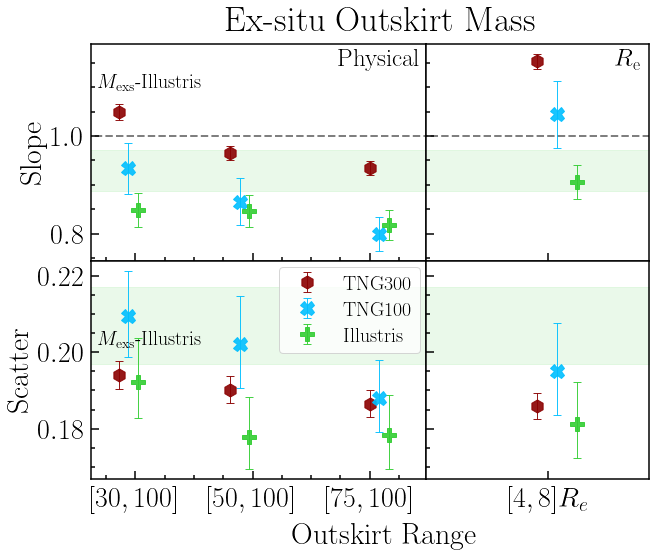

In [27]:
fig=plt.figure(figsize=(10, 8))
gs = fig.add_gridspec(2,2, hspace=0, wspace=0,width_ratios=(0.6,0.4))
(ax21,ax22),(ax41,ax42) = gs.subplots(sharex='col', sharey='row')
projlist=['t300','t100','ori']
color_list=['darkred','deepskyblue','limegreen']
fmtlist=['h','X','P']
mksize_list=[13,14,14]

scatter_aper_tab=scatter_aper_tab0[scatter_aper_tab0['aperture_size']!=75]
slope_aper_tab=slope_aper_tab0[slope_aper_tab0['aperture_size']!=75]
slope_out_tab=slope_out_tab0
scatter_out_tab=scatter_out_tab0
scatter_aper_tab_mock=scatter_aper_tab1[scatter_aper_tab1['aperture_size']!=75]
slope_aper_tab_mock=slope_aper_tab1[slope_aper_tab1['aperture_size']!=75]
slope_out_tab_mock=slope_out_tab1
scatter_out_tab_mock=scatter_out_tab1
apersize=np.asarray([30,60,90,120])
outer=np.asarray([30,50,75])
label_list=['TNG300','TNG100','Illustris']
for ii in range(3):
    mksize=mksize_list[ii]
    label=label_list[ii]
    proj=projlist[ii]
    col=color_list[ii]
    fmt=fmtlist[ii]
    i0=np.asarray([ii,ii,ii])*1.7
    ax21.errorbar(outer+i0,slope_out_tab['slope_out_exs_'+proj],yerr=slope_out_tab['slope_out_exs_'+proj+'_err'],color=col, alpha=0.9, fmt=fmt,
            capsize=4, capthick=1, elinewidth=1, markersize=mksize)
    err1=scatter_out_tab['scatter_out_exs_'+proj]-scatter_out_tab['scatter_out_exs_'+proj+'_err1']
    err2=scatter_out_tab['scatter_out_exs_'+proj+'_err2']-scatter_out_tab['scatter_out_exs_'+proj]
    ax41.errorbar(outer+i0,scatter_out_tab['scatter_out_exs_'+proj],yerr=(err1,err2),color=col, alpha=0.9, 
             capsize=4, capthick=1, elinewidth=1,fmt=fmt,markersize=mksize,label=r'\rm '+label)
"""
for ii in range(3):
    proj=projlist[ii]
    col=color_list[ii]
    fmt=fmtlist[ii]
    i0=np.asarray([ii,ii,ii])*1.7
    ax21.errorbar(outer+i0,slope_out_tab_mock['slope_out_exs_'+proj],mec=col,mfc='White', alpha=0.9, fmt=fmt,
             markersize=10)
    ax41.errorbar(outer+i0,scatter_out_tab_mock['scatter_out_exs_'+proj],mec=col,mfc='White', alpha=0.9, 
             fmt=fmt,markersize=10)
"""


scatter_aper_tab=scatter_aper_tab2[(scatter_aper_tab2['aperture_size']>2)&(scatter_aper_tab2['aperture_size']<9)&(scatter_aper_tab2['aperture_size']!=4)]
slope_aper_tab=slope_aper_tab2[(slope_aper_tab2['aperture_size']>2)&(slope_aper_tab2['aperture_size']<9)&(slope_aper_tab2['aperture_size']!=4)]
slope_out_tab=slope_out_tab2[slope_out_tab2['outskirt_inner_size']==4]
scatter_out_tab=scatter_out_tab2[scatter_out_tab2['outskirt_inner_size']==4]
scatter_aper_tab_mock=scatter_aper_tab3[(scatter_aper_tab3['aperture_size']>2)&(scatter_aper_tab3['aperture_size']<9)&(scatter_aper_tab3['aperture_size']!=4)]
slope_aper_tab_mock=slope_aper_tab3[(slope_aper_tab3['aperture_size']>2)&(slope_aper_tab3['aperture_size']<9)&(slope_aper_tab3['aperture_size']!=4)]
slope_out_tab_mock=slope_out_tab3[slope_out_tab3['outskirt_inner_size']==4]
scatter_out_tab_mock=scatter_out_tab3[scatter_out_tab3['outskirt_inner_size']==4]
apersize=np.asarray([3,6,9])
outer=np.asarray([4])

for ii in range(3):
    mksize=mksize_list[ii]
    label=label_list[ii]
    proj=projlist[ii]
    col=color_list[ii]
    fmt=fmtlist[ii]
    i0=np.asarray([ii])*0.18
    ax22.errorbar(outer+i0,slope_out_tab['slope_out_exs_force_'+proj],yerr=slope_out_tab['slope_out_exs_force_'+proj+'_err'],color=col, alpha=0.9, fmt=fmt,
            capsize=4, capthick=1, elinewidth=1, markersize=mksize)
    err1=scatter_out_tab['scatter_out_exs_force_'+proj]-scatter_out_tab['scatter_out_exs_force_'+proj+'_err1']
    err2=scatter_out_tab['scatter_out_exs_force_'+proj+'_err2']-scatter_out_tab['scatter_out_exs_force_'+proj]
    ax42.errorbar(outer+i0,scatter_out_tab['scatter_out_exs_force_'+proj],yerr=(err1,err2),color=col, alpha=0.9, 
             capsize=4, capthick=1, elinewidth=1,fmt=fmt,markersize=mksize)

"""
for ii in range(3):
    proj=projlist[ii]
    col=color_list[ii]
    fmt=fmtlist[ii]
    i0=np.asarray([ii])*0.18
    ax22.errorbar(outer+i0,slope_out_tab_mock['slope_out_exs_force_'+proj],mec=col,mfc='White', alpha=0.9, fmt=fmt,
             markersize=10)
    ax42.errorbar(outer+i0,scatter_out_tab_mock['scatter_out_exs_force_'+proj],mec=col,mfc='White', alpha=0.9, 
             fmt=fmt,markersize=10)
"""

#ax41.errorbar((10,20),(0.2,0.2),color='black',fmt='h',markersize=10,label=r'\rm Original')
#ax41.errorbar((10,20),(0.2,0.2),mec='black',mfc='White',fmt='h',markersize=10,label=r'\rm + Uncertainty')

x1=np.arange(20,180,20)
x2=np.arange(20,100,10)
y1=slope_exs_tab['xy']+slope_exs_err['xy']+0*x1
y2=slope_exs_tab['xy']-slope_exs_err['xy']+0*x1
y3=scatter_exs_err1['xy']+0*x1
y4=scatter_exs_err2['xy']+0*x1
c0='limegreen'  
ax21.fill_between(x2,y1,y2,alpha=0.1,color=c0) 
ax41.fill_between(x2,y3,y4,alpha=0.1,color=c0)   
ax21.plot(x2,1+0*x2,alpha=0.5,color='black',lw=2,ls='--')

x1=np.arange(2,12,1)
x2=np.arange(2,7,0.5)
y1=slope_exs_tab['xy']+slope_exs_err['xy']+0*x1
y2=slope_exs_tab['xy']-slope_exs_err['xy']+0*x1
y3=scatter_exs_err1['xy']+0*x1
y4=scatter_exs_err2['xy']+0*x1
c0='limegreen'  
ax22.fill_between(x2,y1,y2,alpha=0.1,color=c0)
ax42.fill_between(x2,y3,y4,alpha=0.1,color=c0)  
ax22.plot(x2,1+0*x2,alpha=0.5,color='black',lw=2,ls='--')



ax21.set_xlim(25,85)

ax22.set_xlim(3,5)

ax21.text(0.4, 1.06, r'\rm Ex-situ Outskirt Mass', transform=ax21.transAxes, size=35)

ax41.text(0.6, -0.3, r'\rm Outskirt Range', transform=ax41.transAxes, size=30)
ax21.text(0.74, 0.9, r'\rm Physical', transform=ax21.transAxes, size=25)
ax22.text(0.85, 0.9, r'$R_{\rm e}$', transform=ax22.transAxes, size=25)
#ax21.text(0.45, 0.75, r'\rm Outer size $=100{\rm kpc}$', transform=ax21.transAxes, size=22)
#ax22.text(0.3, 0.75, r'\rm Outer size $=8R_{\rm e}$', transform=ax22.transAxes, size=22)
#ax11.set_title(r'\rm Aperture',fontsize=30)
#ax31.set_xlabel(r'\rm Aperture Size/kpc',fontsize=25)
#ax32.set_xlabel(r'\rm Aperture Size/$R_{\rm e}$',fontsize=25)
ax21.set_ylabel(r'\rm Slope',fontsize=30)
ax41.set_ylabel(r'\rm Scatter',fontsize=30)
#ax21.set_title(r'\rm Outskirt [$\#$,100]kpc',fontsize=30)
ax41.legend(fontsize=20,loc=1,labelspacing=0.4,borderaxespad=0.3)
#ax31.legend(fontsize=25)
#ax41.legend(fontsize=22,loc=1)
#_= ax41.set_xlabel(r'\rm Outskirt Inner Size/kpc',fontsize=25)
#_= ax42.set_xlabel(r'\rm Outskirt Inner Size/$R_{\rm e}$',fontsize=25)
ax41.text(0.02, 0.62, r'$M_{\rm exs}$-{\rm Illustris}', transform=ax41.transAxes, size=20)
ax21.text(0.02, 0.8, r'$M_{\rm exs}$-{\rm Illustris}', transform=ax21.transAxes, size=20)


ax41.set_xticks([33,54,75],[r'$[30,100]$',r'$[50,100]$',r'$[75,100]$'])
ax42.set_xticks([4.1],[r'$[4,8]R_e$'])


#plt.savefig(fig_dir+"Fig6B.png",dpi=100)